<a href="https://colab.research.google.com/github/harihraja/covid-charts/blob/master/Covid_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from google.colab import widgets
from google.colab import output

In [3]:
# Get data file from data.ca.gov
def get_datafile():
  file_name = 'https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv'
  df = pd.read_csv(file_name)
  return df

# calculate the n-Day Rolling Mean (Simple Moving Average)  
def rolling_mean(datafile, size, series_col, groupby_col, value_col, result_col):
  grouper = datafile.groupby(groupby_col)[value_col].rolling(window=size, min_periods=1).mean()
  df_SMA =  grouper.to_frame(name = result_col).reset_index().drop('level_1', axis=1)
  df_SMA[series_col] = df[series_col]

  df_RM = datafile.merge(df_SMA, how='left', left_on=[groupby_col, series_col], right_on=[groupby_col, series_col])

  start_series = df_SMA[series_col].head(1).iloc[0]
  df_RM.loc[df_RM[series_col]==start_series, result_col] = None
  
  return df_RM

In [4]:
# Plot time series for the given states
def plot_timeseries(datafile, regions, title, filter_col, series_col, value_col):
  plt.figure(figsize=[10,8])
  plt.grid(True)


  for region in regions:
    df_SMA_region = datafile[datafile[filter_col]==region]
    dates = pd.to_datetime(df_SMA_region[series_col])
    plt.plot(dates, df_SMA_region[value_col], label=region)

  # plt.ylim(bottom=0.6, top=1.6)
  plt.xlabel('date')
  plt.ylabel('New Cases (Rolling Mean)')
  plt.title(title)
  plt.legend(loc=1)

In [5]:
df = get_datafile() # acquire the data

regions = df['county'].unique() # unique regions
current_date = df['date'].tail(1).iloc[0] # current date

GROUP_SIZE = 5 # For Most Viral Groups
df

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date
0,Santa Clara,151.0,6.0,151,6,2020-03-18
1,Santa Clara,183.0,8.0,32,2,2020-03-19
2,Santa Clara,246.0,8.0,63,0,2020-03-20
3,Santa Clara,269.0,10.0,23,2,2020-03-21
4,Santa Clara,284.0,13.0,15,3,2020-03-22
...,...,...,...,...,...,...
7140,Yolo,833.0,28.0,39,0,2020-07-11
7141,Yolo,889.0,28.0,56,0,2020-07-12
7142,Yolo,941.0,28.0,52,0,2020-07-13
7143,Yolo,966.0,29.0,25,1,2020-07-14


In [46]:
# df.groupby('date')['newcountconfirmed'].sum()


,date,newcountconfirmed,sub_region
0,2020-03-18,125,So Cal
1,2020-03-19,235,So Cal
2,2020-03-20,76,So Cal
3,2020-03-21,90,So Cal
4,2020-03-22,119,So Cal
...,...,...,...
115,2020-07-11,4223,So Cal
116,2020-07-12,4878,So Cal
117,2020-07-13,3536,So Cal
118,2020-07-14,5740,So Cal


In [53]:
sub_regions = {
    'Bay Area': ['San Francisco', 'Alameda', 'Santa Clara', 'San Mateo', 'Contra Costa', 'Marin', 'Sonoma', 'Napa', 'Solano'],
    'So Cal': ['Los Angeles', 'Orange', 'San Diego'],
    'Inland Empire': ['Riverside', 'San Bernadino', 'Imperial'],
    'Central Coast': ['Santa Barbara', 'San Luis Obispo', 'Monterey', 'Santa Cruz', 'San Benito', 'Ventura'],
    'Central Valley': ['Fresno', 'Kern', 'San Joaquin', 'Stanislaus', 'Tulare', 'Merced', 'Madera', 'Kings'],
    'North Coast': ['Mendocino', 'Humboldt', 'Lake', 'Del Norte'],
    'Sacramento Valley': ['Sacramento', 'Sutter', 'Yolo', 'Butte', 'Yuba', 'Tehama', 'Colusa', 'Glenn'],
    'Gold Country': ['Placer', 'El Dorado', 'Nevada', 'Tuolumne', 'Calaveras', 'Amador', 'Mariposa', 'Sierra'],
    'Eastern Sierra': ['Inyo', 'Mono', 'Alpine'],
    'Shasta Cascades': ['Shasta', 'Siskiyou', 'Lassen', 'Trinity', 'Modoc', 'Plumas'],
    }

sub_regions_df = pd.DataFrame()
for sub_region in sub_regions.keys():
  counties = sub_regions[sub_region]
  grpr = df[df.county.isin(counties)].groupby('date')['newcountconfirmed'].sum()
  f = grpr.to_frame(name = 'newcountconfirmed').reset_index()
  f['sub_region'] = sub_region

  sub_regions_df = pd.concat([sub_region_df, f], ignore_index=True) if not sub_region_df.empty else f

sub_regions_df

,date,newcountconfirmed,sub_region
0,2020-03-18,388,Bay Area
1,2020-03-19,68,Bay Area
2,2020-03-20,108,Bay Area
3,2020-03-21,66,Bay Area
4,2020-03-22,78,Bay Area
...,...,...,...
1315,2020-07-11,17,Shasta Cascades
1316,2020-07-12,7,Shasta Cascades
1317,2020-07-13,13,Shasta Cascades
1318,2020-07-14,32,Shasta Cascades


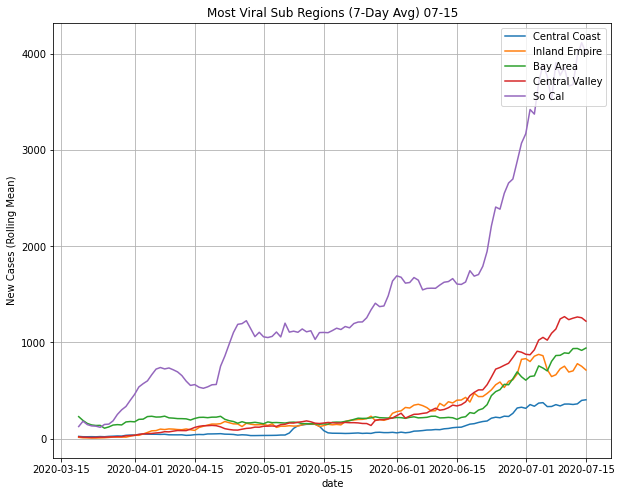

In [63]:
DAY_TABS = { 1: 'Current', 14: '14-Day Avg', 3: '3-Day Avg', 7: '7-Day Avg' }
days = 7

region_col = 'sub_region'
df_SMA = rolling_mean(sub_regions_df, days, 'date', region_col, 'newcountconfirmed', 'rolling_mean')

df_SMA_current = df_SMA.groupby(region_col).tail(1)
sorted_df_SMA = df_SMA_current.sort_values(by=['rolling_mean'], na_position='first')
sorted_regions = sorted_df_SMA[region_col]

title = 'Most Viral Sub Regions (' + DAY_TABS[days] + ') ' + current_date[-5:]
plot_timeseries(df_SMA, sorted_regions.tail(GROUP_SIZE), title, region_col, 'date', 'rolling_mean')